In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)


**1.** Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [3]:
query = '''SELECT f.film_id, i.inventory_id, f.rental_duration, f.rental_rate, f.length, f.rating, r.rental_date, c.name as category
FROM sakila.film f
JOIN film_category as fc 
USING (film_id)
JOIN category as c 
USING (category_id)
JOIN sakila.inventory i 
USING (film_id)
JOIN sakila.rental r 
USING (inventory_id)
WHERE (r.rental_date BETWEEN '2005-01-01' AND '2005-12-31') OR r.rental_date IS NULL
GROUP BY f.film_id
ORDER BY f.film_id;'''

df1= pd.read_sql_query(query, engine)
df1.head()


,film_id,inventory_id,rental_duration,rental_rate,length,rating,rental_date,category
0,1,1,6,0.99,86,PG,2005-07-08 19:03:15,Documentary
1,2,9,3,4.99,48,G,2005-08-01 04:24:47,Horror
2,3,12,7,2.99,50,NC-17,2005-07-27 01:21:19,Documentary
3,4,16,5,2.99,117,G,2005-07-12 02:40:41,Horror
4,5,23,6,2.99,130,G,2005-05-28 07:53:38,Family


In [4]:
df1.shape

(958, 8)

In [5]:
df1.isna().sum()

film_id            0
inventory_id       0
rental_duration    0
rental_rate        0
length             0
rating             0
rental_date        0
category           0
dtype: int64

**2.** Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). This would be our target variable.

In [6]:
query = '''SELECT f.film_id, r.rental_date
FROM sakila.film f
JOIN sakila.inventory i 
USING (film_id) 
JOIN sakila.rental r
USING (inventory_id)
WHERE (r.rental_date BETWEEN "2005-01-01" AND "2005-12-31") OR r.rental_date IS NULL
GROUP BY f.film_id
ORDER BY f.film_id;'''

df2 = pd.read_sql_query(query, engine)
df2.head()

,film_id,rental_date
0,1,2005-05-27 07:03:28
1,2,2005-07-07 19:46:51
2,3,2005-05-31 04:50:07
3,4,2005-05-27 20:44:36
4,5,2005-05-28 07:53:38


In [7]:
df2.shape

(958, 2)

In [8]:
df2['month'] = df2['rental_date'].dt.month
df2.head()

,film_id,rental_date,month
0,1,2005-05-27 07:03:28,5
1,2,2005-07-07 19:46:51,7
2,3,2005-05-31 04:50:07,5
3,4,2005-05-27 20:44:36,5
4,5,2005-05-28 07:53:38,5


In [9]:
# count_may = df2[df2['month'] == 5] ##--- 686 rows
# count_may

In [10]:
df2 = df2.drop(['rental_date'], axis=1)
df2.head()

,film_id,month
0,1,5
1,2,7
2,3,5
3,4,5
4,5,5


In [11]:
def boolean_indicating_may(x):
    if x == 5:
        return 1
    else:
        return 0
df2['month'] = df2['month'].apply(boolean_indicating_may)

df2.head()

,film_id,month
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


**3.** Read the data into a Pandas dataframe.

In [12]:
data = pd.merge(left = df1,
                right = df2,
                how = 'inner', 
                left_on = "film_id", 
                right_on= "film_id")
display(data.shape)
data.head()

(958, 9)

,film_id,inventory_id,rental_duration,rental_rate,length,rating,rental_date,category,month
0,1,1,6,0.99,86,PG,2005-07-08 19:03:15,Documentary,1
1,2,9,3,4.99,48,G,2005-08-01 04:24:47,Horror,0
2,3,12,7,2.99,50,NC-17,2005-07-27 01:21:19,Documentary,1
3,4,16,5,2.99,117,G,2005-07-12 02:40:41,Horror,1
4,5,23,6,2.99,130,G,2005-05-28 07:53:38,Family,1


In [13]:
# table1 = pd.read_sql_table('category', engine)  
# table1

**4.** Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [14]:
data.dtypes

film_id                     int64
inventory_id                int64
rental_duration             int64
rental_rate               float64
length                      int64
rating                     object
rental_date        datetime64[ns]
category                   object
month                       int64
dtype: object

In [15]:
data = data.drop(['rental_date'], axis=1)
data.head()

,film_id,inventory_id,rental_duration,rental_rate,length,rating,category,month
0,1,1,6,0.99,86,PG,Documentary,1
1,2,9,3,4.99,48,G,Horror,0
2,3,12,7,2.99,50,NC-17,Documentary,1
3,4,16,5,2.99,117,G,Horror,1
4,5,23,6,2.99,130,G,Family,1


In [16]:
# data['month'] = data['month'].astype('object')
# data.dtypes

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

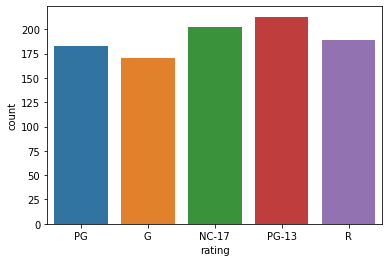

In [18]:
sns.countplot(x=data['rating']);

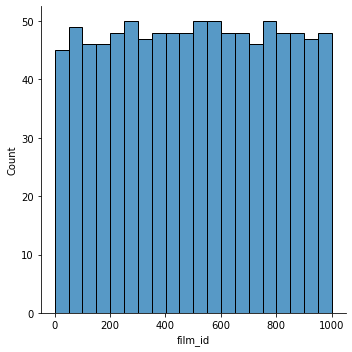

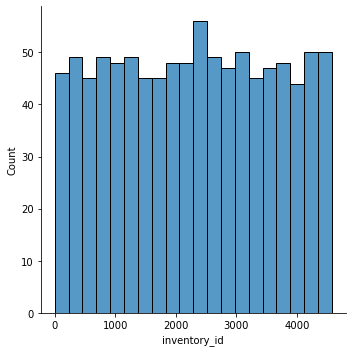

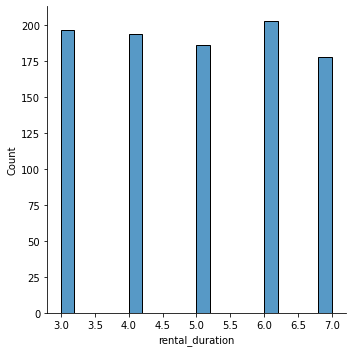

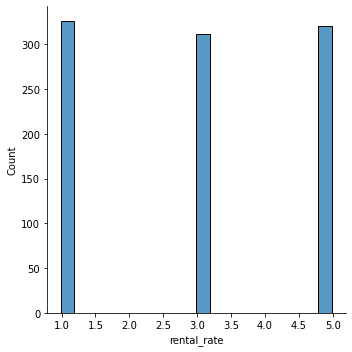

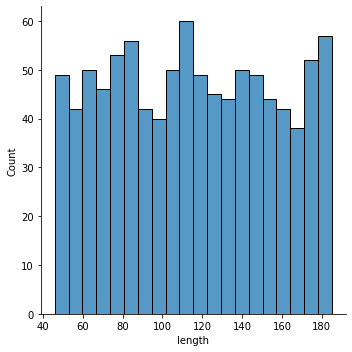

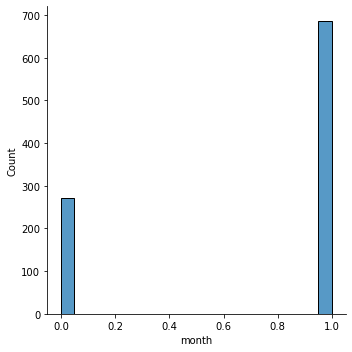

In [19]:
numericals = data.select_dtypes(np.number)

for i in numericals.columns:
    sns.displot(x = i, data = numericals, bins=20)
    plt.show()

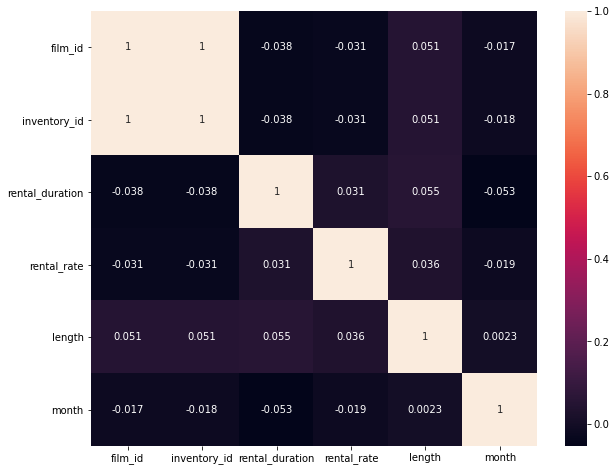

In [20]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [21]:
data = data.drop(['inventory_id'], axis=1)
data.head()

,film_id,rental_duration,rental_rate,length,rating,category,month
0,1,6,0.99,86,PG,Documentary,1
1,2,3,4.99,48,G,Horror,0
2,3,7,2.99,50,NC-17,Documentary,1
3,4,5,2.99,117,G,Horror,1
4,5,6,2.99,130,G,Family,1


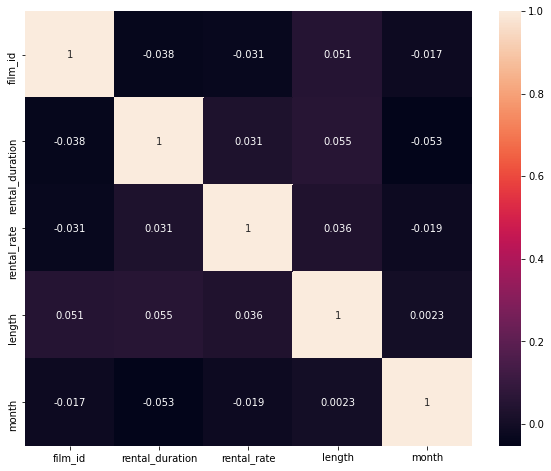

In [22]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [23]:
y = data['month']
X = data.drop('month', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

In [24]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [25]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,film_id,rental_duration,rental_rate,length
0,0.394183,0.50,1.0,0.115108
1,0.219659,0.25,1.0,0.129496
2,0.900702,0.00,0.0,0.690647
3,0.695085,0.75,0.0,0.489209
4,0.919759,0.00,0.0,0.115108


In [26]:
X_train_categorical = X_train.select_dtypes(include = np.object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating','category'],
                             drop_first=True)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
374,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
205,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
863,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
666,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [28]:
X_train_transformed

array([[0.39418255, 0.5       , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21965898, 0.25      , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.90070211, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.65295888, 0.25      , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.69809428, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.89669007, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [29]:
y_train

374    1
205    0
863    1
666    1
881    1
      ..
323    0
671    1
626    1
669    0
859    1
Name: month, Length: 766, dtype: int64

**5.** Create a logistic regression model to predict this variable from the cleaned data.

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
# classification = LogisticRegression(random_state=0, solver='lbfgs',
#                   multi_class='multinomial').fit(X_train_transformed, y_train)

In [32]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [33]:
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [34]:
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating', 'category'],
                            drop_first=True)

In [35]:
X_test_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
733,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
488,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
528,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
885,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
487,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))

[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('category_Animation', 'category_Animation'),
 ('category_Children', 'category_Children'),
 ('category_Classics', 'category_Classics'),
 ('category_Comedy', 'category_Comedy'),
 ('category_Documentary', 'category_Documentary'),
 ('category_Drama', 'category_Drama'),
 ('category_Family', 'category_Family'),
 ('category_Foreign', 'category_Foreign'),
 ('category_Games', 'category_Games'),
 ('category_Horror', 'category_Horror'),
 ('category_Music', 'category_Music'),
 ('category_New', 'category_New'),
 ('category_Sci-Fi', 'category_Sci-Fi'),
 ('category_Sports', 'category_Sports'),
 ('category_Travel', 'category_Travel')]

In [37]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [38]:
predictions = classification.predict(X_test_transformed)

In [39]:
classification.score(X_test_transformed, y_test)

0.78125

In [40]:
print(y_test.value_counts())

1    149
0     43
Name: month, dtype: int64


In [41]:
pd.Series(predictions).value_counts()

1    191
0      1
dtype: int64

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  1,  42],
       [  0, 149]], dtype=int64)

In [43]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.6979166666666666

In [44]:
confusion_matrix(y_test, predictions_clf)

array([[  8,  35],
       [ 23, 126]], dtype=int64)

In [45]:
pd.Series(y_test).value_counts()

1    149
0     43
Name: month, dtype: int64

In [46]:
pd.Series(predictions_clf).value_counts()

1    161
0     31
dtype: int64

### BONUS: Use information for June instead of May

In [47]:
query = '''SELECT f.film_id, r.rental_date
FROM sakila.film f
JOIN sakila.inventory i 
USING (film_id) 
JOIN sakila.rental r
USING (inventory_id)
WHERE (r.rental_date BETWEEN "2005-01-01" AND "2005-12-31") OR r.rental_date IS NULL
GROUP BY f.film_id
ORDER BY f.film_id;'''

df3 = pd.read_sql_query(query, engine)
df3.head()

,film_id,rental_date
0,1,2005-05-27 07:03:28
1,2,2005-07-07 19:46:51
2,3,2005-05-31 04:50:07
3,4,2005-05-27 20:44:36
4,5,2005-05-28 07:53:38


In [48]:
df3['month'] = df3['rental_date'].dt.month

In [49]:
def boolean_indicating_june(x):
    if x == 6:
        return 1
    else:
        return 0
df3['month'] = df3['month'].apply(boolean_indicating_june)

In [50]:
data2 = pd.merge(left = df1,
                right = df3,
                how = 'inner', 
                left_on = "film_id", 
                right_on= "film_id")
display(data2.shape)
data2.head()

(958, 10)

,film_id,inventory_id,rental_duration,rental_rate,length,rating,rental_date_x,category,rental_date_y,month
0,1,1,6,0.99,86,PG,2005-07-08 19:03:15,Documentary,2005-05-27 07:03:28,0
1,2,9,3,4.99,48,G,2005-08-01 04:24:47,Horror,2005-07-07 19:46:51,0
2,3,12,7,2.99,50,NC-17,2005-07-27 01:21:19,Documentary,2005-05-31 04:50:07,0
3,4,16,5,2.99,117,G,2005-07-12 02:40:41,Horror,2005-05-27 20:44:36,0
4,5,23,6,2.99,130,G,2005-05-28 07:53:38,Family,2005-05-28 07:53:38,0


In [51]:
data2.dtypes

film_id                     int64
inventory_id                int64
rental_duration             int64
rental_rate               float64
length                      int64
rating                     object
rental_date_x      datetime64[ns]
category                   object
rental_date_y      datetime64[ns]
month                       int64
dtype: object

In [52]:
columns = ['rental_date_x', 'rental_date_y', 'inventory_id']
data2.drop(columns, inplace=True, axis=1)
data2.head()

,film_id,rental_duration,rental_rate,length,rating,category,month
0,1,6,0.99,86,PG,Documentary,0
1,2,3,4.99,48,G,Horror,0
2,3,7,2.99,50,NC-17,Documentary,0
3,4,5,2.99,117,G,Horror,0
4,5,6,2.99,130,G,Family,0


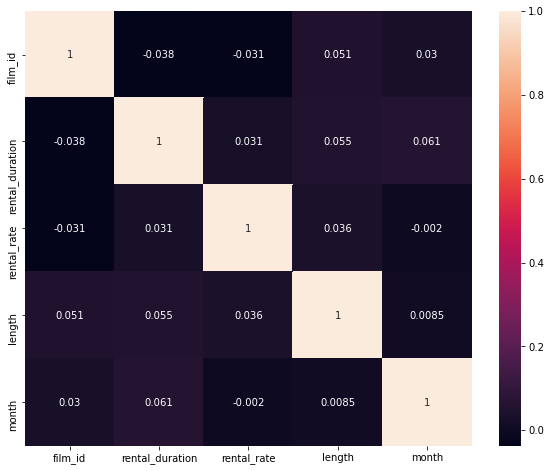

In [53]:
corr_matrix=data2.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [66]:
y = data2['month']
X = data2.drop('month', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

In [67]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [68]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,film_id,rental_duration,rental_rate,length
0,0.394183,0.50,1.0,0.115108
1,0.219659,0.25,1.0,0.129496
2,0.900702,0.00,0.0,0.690647
3,0.695085,0.75,0.0,0.489209
4,0.919759,0.00,0.0,0.115108


In [69]:
X_train_categorical = X_train.select_dtypes(include = np.object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating','category'],
                             drop_first=True)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
374,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
205,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
863,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
666,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [70]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [73]:
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [74]:
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating', 'category'],
                            drop_first=True)

In [75]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [76]:
predictions = classification.predict(X_test_transformed)

In [77]:
classification.score(X_test_transformed, y_test)

0.8333333333333334

In [78]:
print(y_test.value_counts())

0    160
1     32
Name: month, dtype: int64


In [79]:
pd.Series(predictions).value_counts()

0    192
dtype: int64

In [80]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[160,   0],
       [ 32,   0]], dtype=int64)

In [81]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.8125

In [82]:
confusion_matrix(y_test, predictions_clf)

array([[150,  10],
       [ 26,   6]], dtype=int64)

In [83]:
pd.Series(y_test).value_counts()

0    160
1     32
Name: month, dtype: int64

In [84]:
pd.Series(predictions_clf).value_counts()

0    176
1     16
dtype: int64